# BRCA TGFb-CAF

In [40]:
import pandas as pd
import numpy as np 
import math 
import matplotlib.cm as cm 
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from clinical_analysis.visualizations import visualizations as vis

# adding parent directory to the system path
import sys
sys.path.insert(0, '..')
import utils, plot_utils, stats_utils 

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
pa_colors = pd.Series({'spacecadet': '#2D2849',
 'darkgreen': '#195866',
 'mediumgreen': '#2AA095',
 'violet': '#793EF8',
 'turquoise': '#4CEAD3',
 'raspberry': '#C5304B',
 'darkgray': '#333132',
 'lightgray': '#EEEEEE',
 'lightviolet': '#EBE2FE',
 'lightgreen': '#E1EFED',
 '_darkblue': '#173D52',
 '_lightblue': '#16B2E1',
 '_purple': '#852693',
 '_red': '#E11C29'})

colormap_tgfbeta = {'TGFb-CAF high': pa_colors['turquoise'], 
                    'TGFb-CAF low': pa_colors['violet']}


## Read in data

Read in data:

In [43]:
nuhifs = pd.read_csv('data/nuhifs_test_set_only.csv').set_index('slideID')
model_pred_binary = nuhifs.pop('model_prediction')
model_prediction = model_pred_binary.replace({0: 'TGFb-CAF low', 1: 'TGFb-CAF high'})

In [44]:
nuhifs.shape

(186, 240)

## Remove orientation HIFs

In [45]:
nuhifs = nuhifs.loc[:, ~nuhifs.columns.str.contains('ORIENTATION')]

In [46]:
nuhifs.shape

(186, 230)

## Compare distributions

In [47]:
_, df_mwh = stats_utils.compare_hif_distributions(nuhifs, model_prediction)

In [48]:
df_mwh['cell'] = df_mwh.index.map(utils.get_cell) 
df_mwh['property type'] = df_mwh.index.map(utils.get_property_type) 
df_mwh['hif type'] = df_mwh.index.map(utils.get_hif_type)
df_mwh['property'] = df_mwh.index.map(utils.get_property) 


In [49]:
df_mwh.iloc[:10, :].round(3)

,statistic,pvalue,pvalue_corrected,cell,property type,hif type,property
MEAN[LYMPHOCYTE_NUCLEUS_ECCENTRICITY]_H & E,6496.0,0.0,0.0,LYMPHOCYTE,Shape,MEAN,ECCENTRICITY
STD[LYMPHOCYTE_NUCLEUS_ECCENTRICITY]_H & E,149.0,0.0,0.0,LYMPHOCYTE,Shape,STD,ECCENTRICITY
STD[FIBROBLAST_NUCLEUS_PERIMETER]_H & E,6209.0,0.0,0.0,FIBROBLAST,Size,STD,PERIMETER
STD[FIBROBLAST_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E,6127.0,0.0,0.0,FIBROBLAST,Size,STD,MAJOR_AXIS_LENGTH
MEAN[LYMPHOCYTE_NUCLEUS_CIRCULARITY]_H & E,664.0,0.0,0.0,LYMPHOCYTE,Shape,MEAN,CIRCULARITY
STD[FIBROBLAST_NUCLEUS_AREA]_H & E,5938.0,0.0,0.0,FIBROBLAST,Size,STD,AREA
STD[FIBROBLAST_NUCLEUS_MINOR_AXIS_LENGTH]_H & E,5934.0,0.0,0.0,FIBROBLAST,Size,STD,MINOR_AXIS_LENGTH
STD[FIBROBLAST_NUCLEUS_CIRCULARITY]_H & E,5512.0,0.0,0.0,FIBROBLAST,Shape,STD,CIRCULARITY
STD[LYMPHOCYTE_NUCLEUS_PERIMETER]_H & E,5157.0,0.0,0.0,LYMPHOCYTE,Size,STD,PERIMETER
MEAN[FIBROBLAST_NUCLEUS_MIN_GRAYSCALE_CHANNEL_GRAY]_H & E,5058.0,0.0,0.0,FIBROBLAST,Color,MEAN,MIN_GRAYSCALE_CHANNEL_GRAY


Text(0, 0.5, 'Uncorrected p-values (-log$_{10}$(p))')

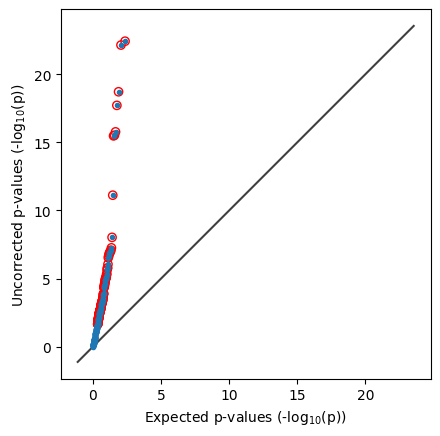

In [50]:
reject = df_mwh['pvalue_corrected'] < 0.05
fig, ax = vis.qq_plot_pvals(df_mwh['pvalue'], rejected_h0=reject)
ax.set_ylabel("Uncorrected p-values (-log$_{10}$(p))")
#fig.savefig('output/fig_4d_qqplot_pvals_mwu_nuclei.svg', bbox_inches='tight', dpi=500)

### Mann-Whitney U Test

Mann-Whitney U test results showing the top 10 HIFs:

In [51]:
df_mwh.iloc[:10, :]

,statistic,pvalue,pvalue_corrected,cell,property type,hif type,property
MEAN[LYMPHOCYTE_NUCLEUS_ECCENTRICITY]_H & E,6496.0,3.817676e-23,8.426751e-21,LYMPHOCYTE,Shape,MEAN,ECCENTRICITY
STD[LYMPHOCYTE_NUCLEUS_ECCENTRICITY]_H & E,149.0,7.327610e-23,8.426751e-21,LYMPHOCYTE,Shape,STD,ECCENTRICITY
STD[FIBROBLAST_NUCLEUS_PERIMETER]_H & E,6209.0,1.962206e-19,1.504358e-17,FIBROBLAST,Size,STD,PERIMETER
STD[FIBROBLAST_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E,6127.0,1.950128e-18,1.121323e-16,FIBROBLAST,Size,STD,MAJOR_AXIS_LENGTH
MEAN[LYMPHOCYTE_NUCLEUS_CIRCULARITY]_H & E,664.0,1.717030e-16,7.898336e-15,LYMPHOCYTE,Shape,MEAN,CIRCULARITY
STD[FIBROBLAST_NUCLEUS_AREA]_H & E,5938.0,3.036347e-16,1.106054e-14,FIBROBLAST,Size,STD,AREA
STD[FIBROBLAST_NUCLEUS_MINOR_AXIS_LENGTH]_H & E,5934.0,3.366250e-16,1.106054e-14,FIBROBLAST,Size,STD,MINOR_AXIS_LENGTH
STD[FIBROBLAST_NUCLEUS_CIRCULARITY]_H & E,5512.0,7.597084e-12,2.184162e-10,FIBROBLAST,Shape,STD,CIRCULARITY
STD[LYMPHOCYTE_NUCLEUS_PERIMETER]_H & E,5157.0,9.411343e-09,2.405121e-07,LYMPHOCYTE,Size,STD,PERIMETER
MEAN[FIBROBLAST_NUCLEUS_MIN_GRAYSCALE_CHANNEL_GRAY]_H & E,5058.0,5.545404e-08,1.275443e-06,FIBROBLAST,Color,MEAN,MIN_GRAYSCALE_CHANNEL_GRAY


In [52]:
df_mwh.cell.value_counts()

LYMPHOCYTE           46
FIBROBLAST           46
MACROPHAGE           46
PLASMA               46
CANCER EPITHELIAL    46
Name: cell, dtype: int64

## Visualize mann-whitney u test results

In [53]:
cell_types = ['CANCER EPITHELIAL', 'FIBROBLAST', 'PLASMA','LYMPHOCYTE',  
              'MACROPHAGE']
cell_types_labels = ['Cancer\ncells','Fibroblast\ncells', 'Plasma\ncells',   'Lymphocyte\ncells',
                     'Macrophage\ncells']
property_types = ['Size', 'Shape']

In [54]:
cell_type_palette = {'CANCER EPITHELIAL': '#F93A00', 
                     'FIBROBLAST': '#FB8741', 
                     'PLASMA': '#FFEEAC', 
                     'LYMPHOCYTE': '#36B279',  
                     'MACROPHAGE': '#015f7d'}

### all HIFs

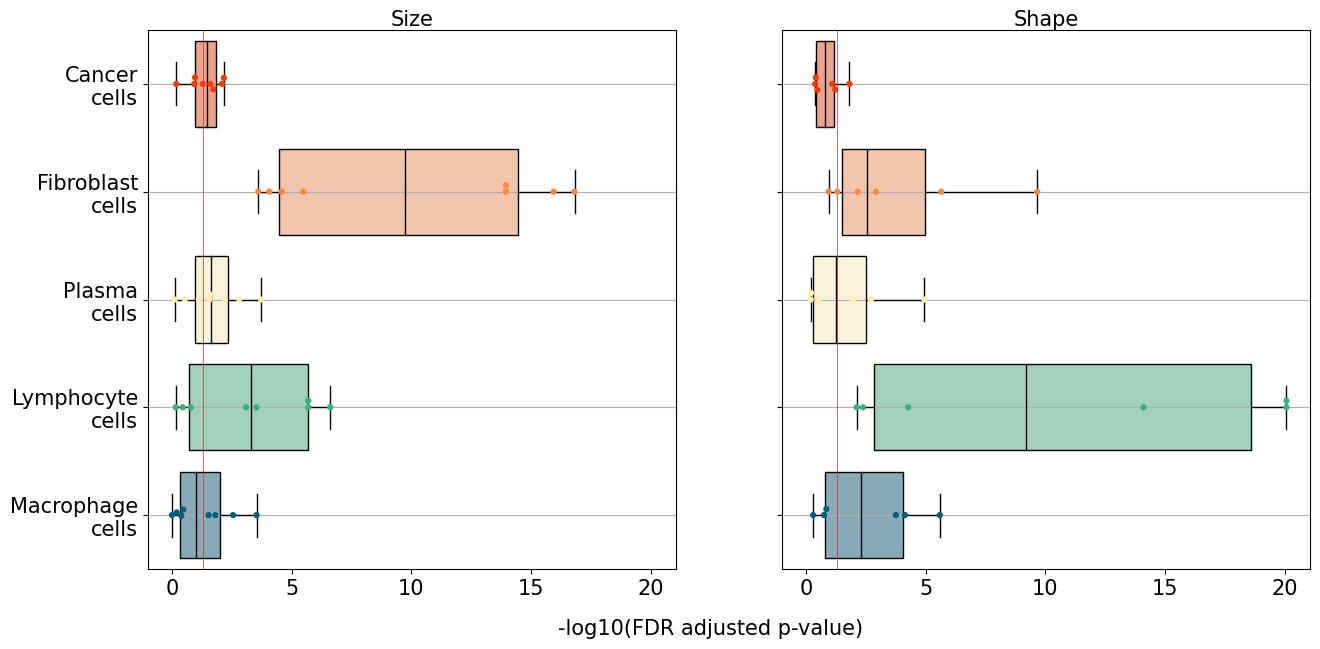

In [56]:
plot_utils.boxplots_pvals_by_groupx_and_groupy(df_mwh, property_types, cell_types, 
                                               groupx_col='property type',
                                               groupy_col='cell',
                                               groupy_labels=cell_types_labels,
                                               title='',
                                               colors=pa_colors[[ 'violet', '_purple', 'mediumgreen',]],
                                               palette=cell_type_palette)#,
                                               #fname='output/nuhifs_mwh_pvals.eps',
                                               #figsize=(11,7))#,
                                               #format='eps',)

### Shape HIFs 

In [58]:
property_shape = np.unique(df_mwh.loc[(df_mwh['property type'] == 'Shape'), 'property'])
property_shape

array(['CIRCULARITY', 'ECCENTRICITY', 'SOLIDITY'], dtype=object)

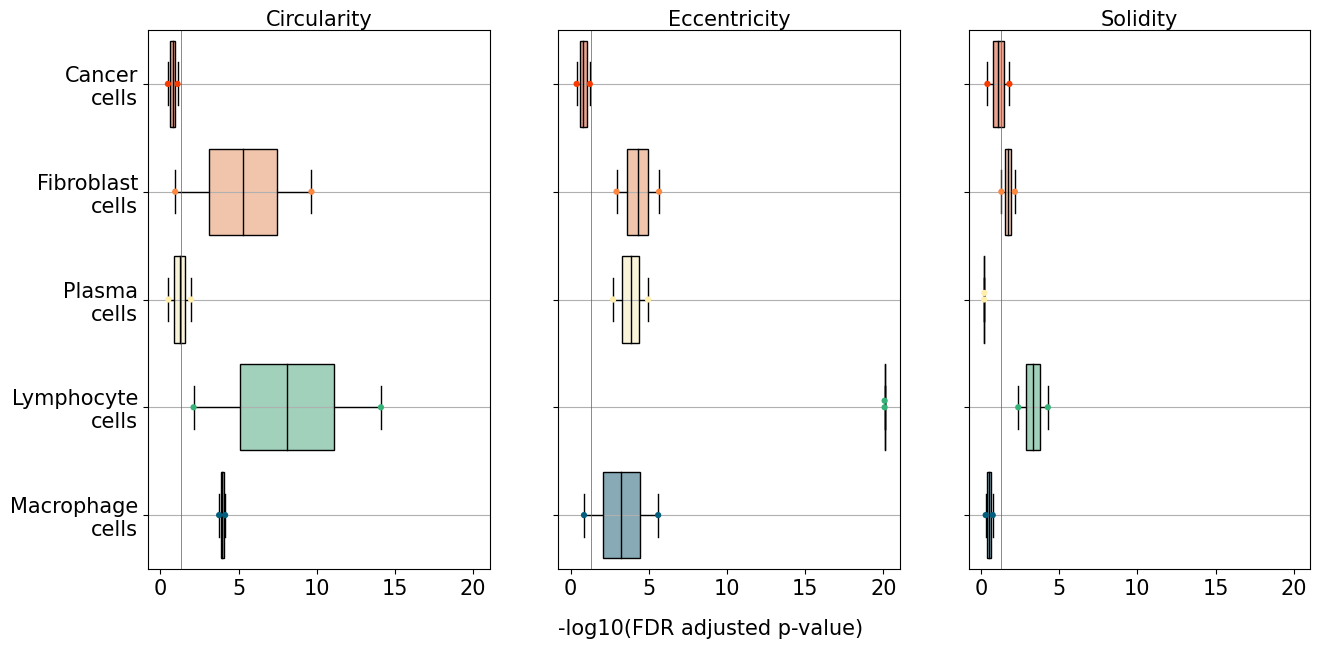

In [59]:

plot_utils.boxplots_pvals_by_groupx_and_groupy(df_mwh, property_shape, cell_types, 
                                               groupx_col='property',
                                               groupy_col='cell',
                                               groupy_labels=cell_types_labels,
                                               groupx_labels=['Circularity', 'Eccentricity', 'Solidity'],
                                               #colors=[pa_colors['_purple'] for i in range(len(property_shape))],
                                               palette=cell_type_palette)#,
                                               #fname='output/fig_4f_nuhifs_shape_mwh_pvals.svg')

### Size HIFs

In [60]:
property_size = np.unique(df_mwh.loc[(df_mwh['property type'] == 'Size'), 'property'])
property_size

array(['AREA', 'MAJOR_AXIS_LENGTH', 'MINOR_AXIS_LENGTH', 'PERIMETER'],
      dtype=object)

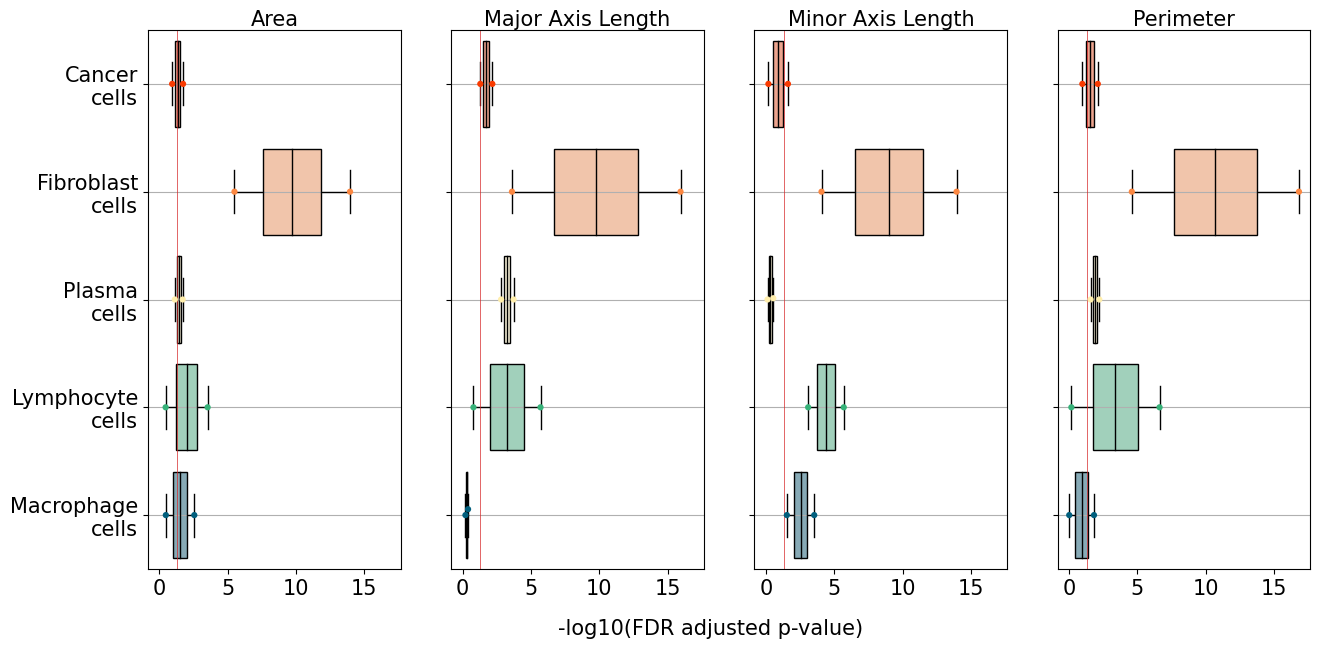

In [61]:
plot_utils.boxplots_pvals_by_groupx_and_groupy(df_mwh, property_size, cell_types, 
                                               groupx_col='property',
                                               groupy_col='cell',
                                               groupy_labels=cell_types_labels,
                                               groupx_labels=['Area', 'Major Axis Length', 'Minor Axis Length', 'Perimeter'],
                                               #colors=[pa_colors['violet'] for i in range(len(property_size))],
                                               palette=cell_type_palette)#,
                                               #fname='output/fig_4f_nuhifs_size_mwh_pvals.svg')
